In [136]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

import sys
import os
from utils.basic_utils import *
from utils.pricing import *
from utils.fundamental import *
from utils.MacroDS import MacroDS
from utils.BaseDS import BaseDS

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.layers import BatchNormalization

pd.options.display.float_format = '{:,.2f}'.format

In [85]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

In [126]:
def pre_process_ds(context):
    
    temp_path = context['tmp_path']
    px_vol_fname = context['px_vol_ds']
    
    benchSL, sectorSL, riskSL, rateSL, bondSL, commSL, currSL = \
    (macro_ds.universe_dict[x] 
     for x in ('benchmarks', 'sectors', 'risk', 'rates', 'bonds', 'commodities', 'currencies'))

    keep_bench = excl(benchSL, ['^STOXX50E', '^AXJO'])
    keep_fx = excl(currSL, ['HKD=X', 'MXN=X', 'AUDUSD=X', 'NZDUSD=X', 'TWD=X', 'CLP=X', 'KRW=X'])
    keep_sect = excl(sectorSL, ['SPY', 'QQQ', 'DIA', 'IWM', 'XLC', 'XLRE'])
    keep_bonds = ['LQD', 'HYG']
    include = riskSL + keep_bench + keep_sect + rateSL + keep_fx + keep_bonds
    
    raw_df = macro_ds.stitch_instruments(symbols=include, name=True, axis=1)

    # clean up empty columns
    empty_cols = raw_df.iloc[-1].loc[raw_df.iloc[-1].isna()].index
    remove_cols = excl(empty_cols, [y_col])
    raw_df.drop(columns=remove_cols, inplace=True)
    print('Pre-clean up shape:', raw_df.shape)

    slim_cols = raw_df.isna().where(raw_df.isna() == True).count().sort_values(ascending=False)
    # keep columns with less than 400 NAs
    keep_cols = list(slim_cols.loc[slim_cols < 400].index)
    raw_df = raw_df[keep_cols]
    print('Post-clean up shape:', raw_df.shape)
    
    fill_on = context['fill']
    scaler_on = context['scale']

    scaler = StandardScaler()
    X_cols = excl(raw_df.columns, [y_col])
    raw_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    if scaler_on: raw_df[X_cols] = scaler.fit_transform(raw_df[X_cols])
    if fill_on: raw_df.loc[:, X_cols] = raw_df.fillna(method=fill_on)

    return raw_df

In [145]:
def get_train_test_sets(context):
    
    raw_df = pre_process_ds(context)

    # discretize forward returns into classes
    cut_range = macro_ds.return_intervals()
    BaseDS.labelize_ycol(raw_df, y_col, cut_range, labels)

    X_cols = excl(raw_df.columns, [y_col])
    
    imputer_on = context['impute']
    imputer = SimpleImputer(
        missing_values=np.nan,
        strategy='median', copy=False)
    if imputer_on: raw_df.loc[:, X_cols] = imputer.fit_transform(raw_df[X_cols])
    else: raw_df.dropna(inplace=True)
        
    test_sz = context['test_size']
        # create training and test sets
    X, y = raw_df.drop(columns=y_col), raw_df[y_col]
    sss = StratifiedShuffleSplit(
        n_splits=1, test_size=test_sz, random_state=42)
    # just one split
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        break
        
    return X_train, X_test, y_train, y_test

In [150]:
def train_ds(context):

    max_iter = context['max_iter']
    l2_reg = context['l2_reg']
    units = context['units']
    trained_cols = context['trained_cols']
    
    X_train, X_test, y_train, y_test = get_train_test_sets(context)
    y_train_oh = pd.get_dummies(y_train)[labels]
    y_test_oh = pd.get_dummies(y_test)[labels]
    
    # Keras Model
    y_train_oh = pd.get_dummies(y_train)[labels]
    y_test_oh = pd.get_dummies(y_test)[labels]

    model = Sequential()
    model.add(Dense(units, input_dim=X_train.shape[1], use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dense(units, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dense(units, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dense(int(units/2), use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dense(len(pd.unique(y_train)), activation='softmax'))
    keras.regularizers.l2(l2_reg)

    ml_path, model_name = context['ml_path'], context['model_name']
    fname = ml_path + model_name
    
    # save training columns
    np.save(ml_path + trained_cols, X_train.columns) # save feature order
    print(f'X_train.shape {X_train.shape}, columns: {list(X_train.columns)}')
    print('Saved: ', ml_path + trained_cols)    

    es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=1)
    checkpointer = ModelCheckpoint(filepath=fname, verbose=1, save_best_only=True)
    csv_logger = CSVLogger('macro-train.log')
    
    opt = Adam()    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    history = model.fit(
        X_train, y_train_oh, validation_data=(X_test, y_test_oh),
        epochs=max_iter, 
        batch_size=64, 
        callbacks=[es, checkpointer, csv_logger])

    score = model.evaluate(X_test, y_test_oh)
    print(f'Loss: {score[0]}, Accuracy: {score[1]}')

In [168]:
def predict_ds(context):

    ml_path = context['ml_path']
    model_name = context['model_name']
    trained_cols = context['trained_cols']
    look_back = context['look_back']

    joined_df = pre_process_ds(context)
    pred_X = joined_df.loc[joined_df.sort_index().index.unique()[-look_back:], :]
    print('pred_X.shape', pred_X.shape)

    # ensure prediction dataset is consistent with trained model
    # save feature order
    train_cols = np.load(ml_path + trained_cols, allow_pickle=True)
    missing_cols = [x for x in train_cols if x not in pred_X.columns]
    if len(missing_cols):
        print(f'Warning missing columns: {missing_cols}')
        for c in missing_cols:
            pred_X[c] = 0

    sorted_cols = list(train_cols)
    print('pred_X.shape', pred_X[sorted_cols].shape)

    pred_df = macro_ds.px_vol_df['close'].loc[pred_X.index, macro_ds.bench].to_frame()

    # Load model
    fname = ml_path + model_name
    model = load_model(fname)
    print('Loaded', fname)

    preds = model.predict(pred_X[sorted_cols])
    preds_classes = model.predict_classes(pred_X[sorted_cols])

    pred_df['pred_class'] = preds_classes
    pred_df['pred_label'] = list(map(lambda x: labels[x], preds_classes))
    probs = np.round(preds, 3)
    # higest prob
    pred_df['confidence'] = [x[np.argmax(x)] for x in probs]
    prob_df = pd.DataFrame(probs, index=pred_df.index, columns=labels)
    pred_df = pd.concat([pred_df, prob_df[labels]], axis=1)
    pred_df.index.name = 'pred_date'

    # store in S3
    s3_path = context['s3_path']
    s3_df = pred_df.reset_index(drop=False)
    rename_col(s3_df, 'index', 'pred_date')
    csv_store(s3_df, s3_path, csv_ext.format(macro_ds.tgt_date))

    return pred_df

In [156]:
context = {
    'portion': 100e-2,
    'ml_path': '../ML/',
    'model_name': 'macro_TF.h5',
    'tmp_path': '../tmp/',
    'px_vol_ds': 'universe-px-vol-ds.h5',
    'trained_cols': 'macro_TF_train_cols.npy',
    'look_ahead': 60,
    'look_back': 252,
    'smooth_window': 10,
    'predict_batch': 252,
    'load_ds': True,
    'impute': True,
    'fill': 'ffill',
    'scale': True,
    'test_size': .10,
    's3_path': 'recommend/macro_ML/',
    'verbose': 2,
    'units': 300,
    'hidden_layers': 4,
    'max_iter': 50,
    'l2_reg': 0.5,
    'dropout': 0.5,
}

In [124]:
%%time
temp_path = context['tmp_path']
px_vol_fname = context['px_vol_ds']

macro_ds = MacroDS(
    path=temp_path, fname=px_vol_fname, load_ds=True, 
    bench='^GSPC',
    look_ahead=60, look_back=252,    
    invert_list=['EURUSD=X', 'GBPUSD=X'], 
    include_list=['^VIX'],
#     max_draw_on=True,
)

y_col = f'{macro_ds.bench}{macro_ds.ycol_name}'
labels = macro_ds.forward_return_labels

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4674 entries, 2004-05-30 to 2019-05-31
Columns: 6380 entries, (high, 0700.HK) to (volume, ^VIX)
dtypes: float32(6380)
memory usage: 113.8 MB
None
Target date: 2019-05-31
Loading file quote/csv/2019-05-31
Loading file summary-categories/assetProfile
OCLHV dataframes
Inverting instruments
Change dataframes
Relative performance dataframes
Relative volume and dollar value dataframes
Realized volatility dataframe
Percentage change stds dataframes
Ranked returns dataframes
Forward return dataframe
CPU times: user 12 s, sys: 870 ms, total: 12.8 s
Wall time: 13.5 s


### Train

In [148]:
%%time
train_ds(context)

Pre-clean up shape: (3776, 697)
Post-clean up shape: (3776, 614)


/Users/vveiga/miniconda3/envs/inception/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/vveiga/miniconda3/envs/inception/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Treshold distributions: [ -inf -0.08 -0.04  0.04  0.07   inf]
neutral   0.50
bull      0.18
long      0.18
short     0.07
bear      0.07
Name: ^GSPCfwdRet60, dtype: float64
X_train.shape (3331, 613), columns: ['^HSIPct200MA', 'FXIPct52WH', 'FXIPct52WL', '^HSIOpenGap', '^GDAXIPct52WH', '^GDAXIPct52WL', '^FTSEPct52WH', '^FTSEPct52WL', 'FXIPerfRank200', 'FXIPctChgStds200', 'FXIPctChg200', 'FXIPct200MA', '^N225Pct50MA', '^N225PctVol50DA', '^FTSEPct200MA', '^GDAXIPct200MA', '^TYXPct52WH', '^TYXPct52WL', '^TNXPct52WH', '^TNXPct52WL', '^FVXPct52WL', '^FVXPct52WH', 'IJHPct52WH', 'XLYPct52WL', 'XLYPct52WH', 'XLVPct52WL', 'IJHPct52WL', 'IJRPct52WH', 'XLVPct52WH', 'XLUPct52WL', 'IJRPct52WL', 'XLIPct52WL', 'EEMPct52WH', 'EEMPct52WL', 'XLBPct52WH', 'XLPPct52WL', 'XLPPct52WH', 'XLEPct52WH', 'XLEPct52WL', 'XLFPct52WH', 'XLKPct52WL', 'XLKPct52WH', 'XLFPct52WL', 'XLUPct52WH', 'XLBPct52WL', 'XLIPct52WH', '^VIXPct52WL', '^RUTPct52WL', '^DJIPct52WH', '^IXICPct52WL', '^DJIPct52WL', '^IXICPct52WH', '^GSPCPc

Train on 3331 samples, validate on 371 samples
Epoch 1/50
3331/3331 [==============================] - 5s 1ms/step - loss: 0.9595 - acc: 0.6424 - val_loss: 0.5409 - val_acc: 0.7871

Epoch 00001: val_loss improved from inf to 0.54086, saving model to ../ML/macro_TF.h5
Epoch 2/50
3331/3331 [==============================] - 1s 276us/step - loss: 0.3909 - acc: 0.8658 - val_loss: 0.3774 - val_acc: 0.8518

Epoch 00002: val_loss improved from 0.54086 to 0.37742, saving model to ../ML/macro_TF.h5
Epoch 3/50
3331/3331 [==============================] - 1s 294us/step - loss: 0.2713 - acc: 0.9054 - val_loss: 0.3903 - val_acc: 0.8571

Epoch 00003: val_loss did not improve from 0.37742
Epoch 4/50
3331/3331 [==============================] - 1s 279us/step - loss: 0.2646 - acc: 0.9183 - val_loss: 0.3409 - val_acc: 0.8976

Epoch 00004: val_loss improved from 0.37742 to 0.34094, saving model to ../ML/macro_TF.h5
Epoch 5/50
3331/3331 [==============================] - 1s 288us/step - loss: 0.2060 - acc

### Predict

In [169]:
%time pred_df = predict_ds(context)

Pre-clean up shape: (3776, 697)
Post-clean up shape: (3776, 614)


/Users/vveiga/miniconda3/envs/inception/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/vveiga/miniconda3/envs/inception/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


pred_X.shape (252, 614)
pred_X.shape (252, 613)
Loaded ../ML/macro_TF.h5
Saved recommend/macro_ML/2019-05-31.csv
CPU times: user 6.25 s, sys: 750 ms, total: 7 s
Wall time: 6.63 s


#### Store / Read S3

In [170]:
# read from S3
s3_path = context['s3_path']
pred_df = pd.read_csv(
    csv_load(f'{s3_path}{macro_ds.tgt_date}'),
    index_col='pred_date', parse_dates=True)

#### Visualize

In [172]:
pred_df.columns

Index(['^GSPC', 'pred_class', 'pred_label', 'confidence', 'bear', 'short',
       'neutral', 'long', 'bull'],
      dtype='object')

In [173]:
# recommendation distribution
print('Prediction distribution')
pd.value_counts(pred_df.pred_label) / pd.value_counts(pred_df.pred_label).sum()

Prediction distribution


neutral   0.42
long      0.23
bull      0.15
short     0.11
bear      0.08
Name: pred_label, dtype: float64

'Confidence Mean: 0.924, Median 0.986'

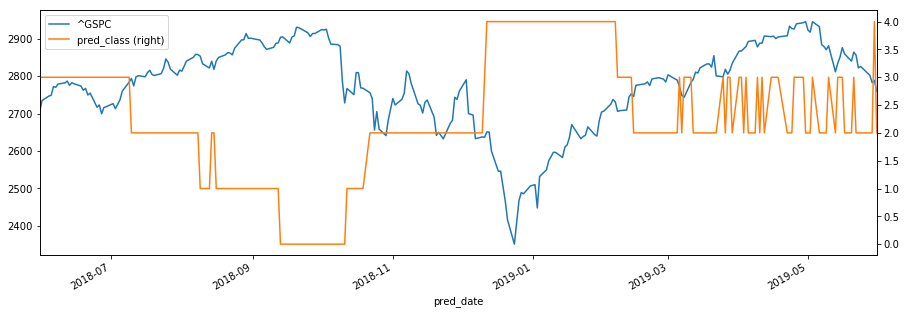

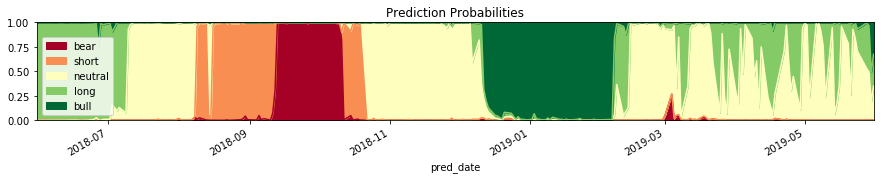

In [176]:
pre_class_cols = filter_cols(pred_df.columns, "pred_class")
pred_df.loc[:,[macro_ds.bench] + pre_class_cols].plot(
    secondary_y=pre_class_cols, figsize=(15, 5));
pred_df[labels].plot.area(
        title='Prediction Probabilities',
        figsize=(15, 2), ylim=(0, 1), cmap='RdYlGn');
f'Confidence Mean: {pred_df["confidence"].mean().round(3)}, Median {pred_df["confidence"].median().round(3)}'

### Sandbox code

#### Dataset creation

In [ ]:
# average the return of the next periods
# select only rows where Y variable is not null
train_idx = px_close.dropna(subset=[bench]).index
Y = px_fwd_rets(px_close.loc[train_idx, bench], bench, pred_fwd_windows).mean(axis=1)
Y.plot.hist(bins=50, title='Distribution of Forwards Returns')
Y.shape

In [ ]:
%%time
df_large = pd.DataFrame()

# rate transforms
rate_ft_df = rate_feats(px_close[rateSL], rate_windows)
df_large[rate_ft_df.columns] = rate_ft_df

# price momentum transforms
super_list = []
for ticker in include:
    inv = ticker in invert
    incl_px = True if ticker in incl_price else False
    df = px_close[ticker]
    ft_df = px_mom_feats(df, ticker, stds, inv, incl_px, sec_windows)
    super_list.append(ft_df.drop_duplicates())
df_large = pd.concat(super_list, axis=1).sort_index()

df_large[y_col] = Y

# drop NAs before discretizing
df_large = df_large.loc[train_idx, :]

print(df_large.shape)

In [ ]:
os.makedirs('tmp', exist_ok=True)
df_large.to_parquet('tmp/macro-ds-large')

#### Metrics

In [ ]:
draw_tree(clf1.estimators_[0], X, precision=3)

In [ ]:
show_fi(clf1, X, 25)

In [ ]:
log_loss(y_test, clf1.predict_proba(X_test))

In [ ]:
print('Confussion Matrix\n', confusion_matrix(clf.predict(X_test), y_test, labels=fwd_ret_labels))

In [ ]:
print('Classificaton report\n', classification_report(clf.predict(X_test), y_test, target_names=fwd_ret_labels))

In [ ]:
fi = rf_feat_importance(clf1, pd.DataFrame(X)); fi[:10]

In [ ]:
clf1.predict_proba(X_test)

In [ ]:
[plt.plot(x.tolist(), alpha=0.1, color='b', marker='*', linewidth=0) for x in clf1.predict_proba(X_test)];

#### Feature construction

In [ ]:
# FX
FX = ['EURUSD=X', 'JPY=X', 'GBPUSD=X', 'CNY=X', 'CHF=X', 'DX-Y.NYB']
invert = ['EURUSD=X', 'GBPUSD=X']
df_raw = px_close[FX]
df_raw.describe().T

In [ ]:
fx_df = df_raw.copy()
fx_df[invert] = (1 / df_raw[invert])
fx_df.tail(252)
fx_chg_df = fx_df.pct_change().rolling(60).sum()
fx_chg_df.plot.kde()

In [ ]:
rates = px_close[rateSL]
rates.plot.kde(alpha=1, title='Yield Curve Rate Distribution')
rate_feats(rates, [60]).plot.kde(title='10Yr - 3M Spread')

In [ ]:
%%time
# Uses px_mom_feats for FX transforms
FX = ['EURUSD=X', 'JPY=X', 'GBPUSD=X', 'CNY=X', 'CHF=X', 'DX-Y.NYB']
invert = ['EURUSD=X', 'GBPUSD=X']

ndf = pd.DataFrame() 
for fx in FX:
    inv = True if fx in invert else False
    df = get_symbol_pricing(fx)
    ft_df = px_mom_feats(df, fx, 1, inv, True)
    ndf[ft_df.columns] = ft_df
ndf.plot.hist(alpha=0.5, legend=False)

In [ ]:
ft_df = px_mom_feats(get_symbol_pricing('^VIX'), '^VIX', 2, False, True, [20])
print(ft_df.columns)
ft_df.iloc[:,:].plot.hist()

In [ ]:
symbol = '^GSPC'
px_df = get_symbol_pricing(symbol)

ft_df = px_mom_feats(px_df, symbol)
# ft_df.plot(subplots=True, figsize=(10,15));
ft_df.plot.hist(alpha=0.5);

In [ ]:
ft_df = px_fwd_rets(px_df, symbol)
ft_df.plot.hist(alpha=0.5);
ft_df[symbol] = px_df['close']
ft_df.tail(252*4).plot(secondary_y=symbol, figsize=(10,5));

In [ ]:
%%time
# average different time frames of fwd rets for all benchmarks
# do we try to estimate the average of all benchmarks or just one?
# do we try to estimate three type of fwd rets [20, 60, 120] or just one?

# calculate forward returns for all bechmarks
fwd_rets_df = pd.DataFrame()
for s in benchSL:
    px_df = get_symbol_pricing(s)
    fwd_ret = px_fwd_rets(px_df, s)
    fwd_rets_df[fwd_ret.columns] = fwd_ret
fwd_rets_df.tail()

[fwd_rets_df[[x for x in fwd_rets_df.columns if y in x]].mean(axis=1).plot.hist(alpha=0.5)
     for y in ['g20', 'g60', 'g120']]

#### Visualizations

In [ ]:
locs = [-int(x**3) for x in range(1, 7, 1)]
px_close[rateSL].iloc[locs, :].T.plot(title='Historical Yield Curve');
#f'Yield curve for the last {locs} days'

In [ ]:
# show correlations with Y variables
show = ['mktFwdChg1m', 'mktFwdChg3m', 'mktFwdChg6m']
ml_ds_df.corr()[show]

In [ ]:
# series distributions
%time ml_ds_df.hist(figsize=(15,15));

In [ ]:
# scatter plots
%time pd.plotting.scatter_matrix(ml_ds_df, alpha=0.1, figsize=(40, 40));

In [ ]:
# historical returns for 1, 3, and 6 months
secpx['mktHistPctChgStds'] = SPY_pct_chg.apply(sign_compare, args=(SPY_pct_chg.std(),))
secpx['mktHistPctChg1m'] = SPY_close.pct_change(periods=20)
secpx['mktHistPctChg3m'] = SPY_close.pct_change(periods=60)
secpx['mktHistPctChg6m'] = SPY_close.pct_change(periods=120)
secpx['mktPerc52WkHigh'] = (SPY_close / SPY_close.rolling(252).max())
secpx['mktPerc52WkLow'] = (SPY_close / SPY_close.rolling(252).min())

show = ['mktHistPctChgStds', 'mktHistPctChg1m', 'mktHistPctChg3m', 
        'mktHistPctChg6m']
secpx[show].hist();
secpx[show].tail(252*4).plot(secondary_y='mktHistPctChgStds');
show = ['mktPerc52WkLow']
secpx[show].tail(252*4).plot();

In [ ]:
# Forward returns, 1w, 1m, 3m
SPY_close.pct_change(5).shift(-5)
secpx['mktFwdChg1m'] = SPY_close.pct_change(20).shift(-20)
secpx['mktFwdChg3m'] = SPY_close.pct_change(60).shift(-60)
secpx['mktFwdChg6m'] = SPY_close.pct_change(120).shift(-120)

show = ['mktFwdChg1m', 'mktFwdChg3m', 'mktFwdChg6m']
secpx[show].hist();
secpx[show].tail(252*4).plot();

In [ ]:
show = [bench_symbol, 'mktFwdChg1m', 'mktFwdChg3m', 'mktFwdChg6m']
secpx[show].tail(252*4).plot(secondary_y=bench_symbol, figsize=(12,5));

In [ ]:
# cumulative deltas and gap analysis
secpx['pctChgStds'] = pct_chg.apply(sign_compare, args=(pct_chg.std(),))
secpx['openGap1m'] = (openpx - closepx.shift(1)).rolling(20).sum()
secpx['hlDelta1m'] = (highpx - lowpx).rolling(20).sum()
secpx['cumChg1m'] = (closepx - closepx.shift(1)).rolling(20).sum()
secpx['cumChg3m'] = (closepx - closepx.shift(1)).rolling(60).sum()
secpx['cumChg6m'] = (closepx - closepx.shift(1)).rolling(120).sum()
secpx['perc52WkLow'] = (closepx / closepx.rolling(252).min())

show = ['pctChgStds', 'openGap1m', 'hlDelta1m', 
        'cumChg1m', 'cumChg3m', 'cumChg6m']
secpx[show].hist();
secpx[show].tail(252*4).plot(secondary_y='pctChgStds');
show = ['perc52WkLow']
secpx[show].tail(252*4).plot();

In [ ]:
show = ['pctChgStds', 'mktHistPctChgStds']
secpx[show].hist();
secpx[show].tail(252*4).plot();

In [ ]:
# rolling SPY correlations
secpx['crossCorr1m'] = closepx.pct_change().rolling(20).corr(SPY_pct_chg)
secpx['crossCorr3m'] = closepx.pct_change().rolling(60).corr(SPY_pct_chg)

show = [bench_symbol, 'crossCorr1m', 'crossCorr3m']
secpx[show].tail(252*4).plot(secondary_y=bench_symbol);
# closepx.pct_change().corr(SPY_pct_chg)

#### Missing values

In [ ]:
# px_close.loc[pred_X.index, keep_bench].tail(20)
# pred_X.tail()

In [ ]:
# pred_X.fillna(method='ffill', inplace=True)
# na = pred_X.tail(120).isna().any(0)
# pred_X[na[na.values].index]

#### Fixing timeseries concatenation

In [ ]:
super_list = []
for n, t in enumerate(keep_sect):
    try:
        df = get_symbol_pricing(t, freq, cols=None)
        rename_col(df, 'close', t)
        print("Retrieving pricing: {0}, {1}".format(t, df.shape))
        df.index = df.index.strftime('%Y-%m-%d')
        super_list.append(df[t])
    except Exception as e:
        print("Exception, get_mults_pricing: {0}\n{1}".format(t, e))

In [ ]:
full_df = pd.DataFrame(super_list[0])
if len(super_list[1:]):
    for x in super_list[1:]: full_df = pd.merge(full_df, x, left_index=True, right_index=True, how='outer')
full_df.index = pd.to_datetime(full_df.index)

In [ ]:
full_df.tail(20)

In [ ]:
super_list[0].tail(10)

In [ ]:
super_list[1].tail(10)

In [ ]:
super_list[2].tail(10)

In [ ]:
get_symbol_pricing('JPY=X')

In [ ]:
full_df.tail(30).sort_index()

In [ ]:
for d in super_list:
    print(d.shape, d.drop_duplicates().shape)

In [ ]:
super_list[1].duplicated().sort_values()

In [ ]:
df = pd.concat(super_list, axis=1)

In [ ]:
super_list[0].tail(10).index, \
super_list[1].tail(10).index, \
super_list[2].tail(10).index, \
super_list[3].tail(10).index

In [ ]:
ss = get_symbol_pricing('DX-Y.NYB', freq).tail(20)

In [ ]:
ss.index.strftime('%Y-%m-%d')

In [ ]:
# pd.merge(super_list[1], super_list[2], left_index=True, right_index=True)
# pd.concat(super_list, axis=1)
init_df = pd.DataFrame(super_list[0])
for x in super_list[1:]:
    init_df = pd.merge(init_df, x, left_index=True, right_index=True)
init_df.tail(60)

In [ ]:
pd.concat(super_list, axis=1, ).tail(15)

In [ ]:
for d in super_list: d.drop_duplicates(inplace=True)

In [ ]:
df = pd.concat(super_list, axis=1, copy=False)